In [34]:
# Doing an import
import gym
from gym import spaces
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import copy
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [36]:
# Checking for cuda
print(torch.cuda.is_available())
print(torch.version.cuda)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
10.2


In [37]:
# Recreating the gridworld environment from assignment 1 with some changes
# Changing reward to +1 for going closer to the goal, -1 for going farther, 0 for remaining in the same state
# Putting max timesteps = 10

class GridDeterministicEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(8)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 1]
        self.state = np.zeros((4,2))
        self.state[tuple(self.agent_pos)] = 1
        
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        prev_pos = copy.deepcopy(self.agent_pos)
        if action == 0:
          self.agent_pos[0] += 1   # Down
        if action == 1:
          self.agent_pos[0] -= 1   # Up
        if action == 2:
          self.agent_pos[1] += 1   # Right
        if action == 3:
          self.agent_pos[1] -= 1   # Left
        
        self.agent_pos[0] = np.clip(self.agent_pos[0], 0, 3)
        self.agent_pos[1] = np.clip(self.agent_pos[1], 0, 1)
        self.state = np.zeros((4,2))
        self.state[tuple(self.agent_pos)] = 1
        
        observation = self.state.flatten()
        
        reward = 0
        if prev_pos != self.agent_pos:
            if self.agent_pos[0] > prev_pos[0] or self.agent_pos[1] > prev_pos[1]:
                reward = 1
            if self.agent_pos[0] < prev_pos[0] or self.agent_pos[1] < prev_pos[1]:
                reward = -1
                
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos) else False
        
        return observation, reward, done, 0
        
    def render(self):
        plt.imshow(self.state)

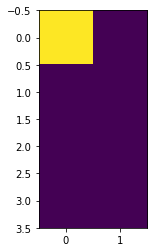

In [38]:
env = GridDeterministicEnvironment()
obs = env.reset()
env.render()

In [39]:
# Creating neural network for the the gridworld environment
class NN(nn.Module):
    def __init__(self, seed):
        super(NN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.hl1 = nn.Linear(8,70)
        self.hl2 = nn.Linear(70,30)
        self.ol = nn.Linear(30,4)
        
    def forward(self, x):
        x = F.relu(self.hl1(x))
        x = F.relu(self.hl2(x))
        x = self.ol(x)
        return x

In [40]:
# Creating a DQN agent for the Gridworld environment
class DQNagent:
    def __init__(self, env, nn, seed):
        self.env = env
        self.observation_space = env.observation_space.n
        self.action_space = env.action_space.n
        self.policy_net = nn(seed).to(device)
        self.target_net = nn(seed).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.curr_mem = 0
        
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.batch_size = 6
        self.gamma = 0.9
        self.decay = math.exp(-1/90)
        self.num_episodes = 70
        self.memory_capacity = 1000
        self.max_time = 10
        self.replay_memory = np.empty(self.num_episodes*self.max_time, object)
        
        random.seed(seed)
        
    def add_memory(self, memory):
        self.replay_memory[self.curr_mem] = memory
        self.curr_mem += 1
        
    def sample(self, sample_size):
        return random.sample(range(0,self.curr_mem), sample_size)
        
    def greedy_action(self, states, eps):
        if random.random() > eps:
            with torch.no_grad():  
                ga = self.policy_net(states)
            self.policy_net.train()
            return torch.argmax(ga)
        else:
            return torch.tensor(random.randrange(self.env.action_space.n), device = device)

    def optimization_time(self):
        if self.curr_mem >= self.batch_size:
            batch = self.sample(self.batch_size)
            states = torch.tensor([self.replay_memory[i][0] for i in batch], dtype = torch.float, device = device)
            rewards = torch.tensor([self.replay_memory[i][2] for i in batch], dtype = torch.float, device = device)
            next_states = torch.tensor([self.replay_memory[i][3] for i in batch], dtype = torch.float, device = device)
            actions = [self.replay_memory[i][1] for i in batch]
            
            policy_action_values = []
            t = 0
            for i in states:
                policy_action_values.append(self.policy_net(i)[actions[t]])
                t = t+1
            
            next_state_values = []
            for i in next_states:
                if i[7] == 1:
                    next_state_values.append(0)
                else:
                    next_all_values = self.target_net(i).detach()
                    next_state_values.append(max(next_all_values))
         
            expected_state_values = [next_state_values[i]*self.gamma + rewards[i] for i in range(len(next_state_values))]
            policy_action_values = torch.stack(tuple(policy_action_values))
            expected_state_values = torch.stack(tuple(expected_state_values))
            
            self.loss = F.smooth_l1_loss(policy_action_values, expected_state_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()  
        
        else:
            return
            
    def start_learning(self):
        self.eps = 0.9
        self.epsilon_whole = []
        self.episode_log = {'actions': [], 'rewards': [], 'epsilon': []}
        for i in range(self.num_episodes):
            self.action_log = []
            self.reward_log = []
            self.epsilon_log = []
            self.env.reset()
            d = False
            while not d:
                state = self.env.state.flatten()
                self.epsilon_log.append(self.eps)
                self.epsilon_whole.append(self.eps)
                action = self.greedy_action(torch.tensor(state,dtype=torch.float,device=device),self.eps)
                self.eps =  self.eps*self.decay
                o,r,d,info = self.env.step(action)
                self.action_log.append(action)
                self.reward_log.append(r)
                self.add_memory([state,action.tolist(),r,o])
                self.optimization_time()
                
            self.episode_log['actions'].append(self.action_log)
            self.episode_log['rewards'].append(self.reward_log)
            self.episode_log['epsilon'].append(self.epsilon_log)
            if i%4 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
        print('complete')   

In [41]:
# Running the DQN agent
env1 = GridDeterministicEnvironment()
obs = env1.reset()
agent1 = DQNagent(env1,NN,123)
agent1.start_learning()

complete


last 5 episode rewards
[[1, 1, 1, 0, 1], [1, 1, 0, 1, 0, 1], [1, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]


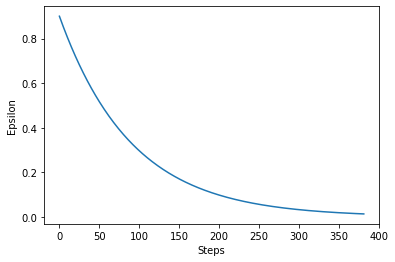

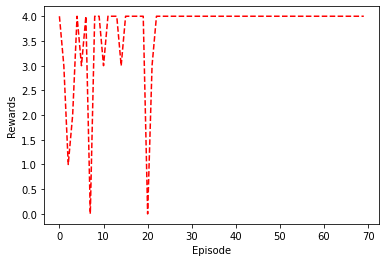

In [43]:
# DQN agent Gridworld environment

# Epsilon Decay
plt.figure()
plt.plot(agent1.epsilon_whole)
plt.ylabel('Epsilon')
plt.xlabel('Steps')

# Reward per Step
qs_rps = []
for i in agent1.episode_log['rewards']:
    t = sum(i)
    qs_rps.append(t)

plt.figure()
plt.plot(qs_rps, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

# Rewards of the last 5 episodes
print('last 5 episode rewards')
print(agent1.episode_log['rewards'][-5:])

In [44]:
# creating a DDQN agent for the gridworld environment
class DDQNagent:
    def __init__(self, env, nn, seed):
        self.env = env
        self.observation_space = env.observation_space.n
        self.action_space = env.action_space.n
        self.policy_net = nn(seed).to(device)
        self.target_net = nn(seed).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.curr_mem = 0
        
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.batch_size = 6
        self.gamma = 0.9
        self.decay = math.exp(-1/90)
        self.num_episodes = 70
        self.memory_capacity = 1000
        self.max_time = 10
        self.replay_memory = np.empty(self.num_episodes*self.max_time, object)
        
        random.seed(seed)
        
    def add_memory(self, memory):
        self.replay_memory[self.curr_mem] = memory
        self.curr_mem += 1
        
    def sample(self, sample_size):
        return random.sample(range(0,self.curr_mem), sample_size)
        
    def greedy_action(self, states, eps):
        if random.random() > eps:
            with torch.no_grad():  
                ga = self.policy_net(states)
            self.policy_net.train()
            return torch.argmax(ga)
        else:
            return torch.tensor(random.randrange(self.env.action_space.n), device = device)

    def optimization_time(self):
        if self.curr_mem >= self.batch_size:
            batch = self.sample(self.batch_size)
            states = torch.tensor([self.replay_memory[i][0] for i in batch], dtype = torch.float, device = device)
            rewards = torch.tensor([self.replay_memory[i][2] for i in batch], dtype = torch.float, device = device)
            next_states = torch.tensor([self.replay_memory[i][3] for i in batch], dtype = torch.float, device = device)
            actions = [self.replay_memory[i][1] for i in batch]
            
            policy_action_values = []
            t = 0
            for i in states:
                policy_action_values.append(self.policy_net(i)[actions[t]])
                t = t+1
            
            next_state_values = []
            for i in next_states:
                if i[7] == 1:
                    next_state_values.append(0)
                else:
                    next_best_states = self.target_net(i).detach()
                    next_best_state = torch.argmax(next_best_states)
                    next_svs = self.policy_net(i).detach()
                    next_state_values.append(next_svs[next_best_state])
         
            expected_state_values = [next_state_values[i]*self.gamma + rewards[i] for i in range(len(next_state_values))]
            policy_action_values = torch.stack(tuple(policy_action_values))
            expected_state_values = torch.stack(tuple(expected_state_values))
            
            self.loss = F.smooth_l1_loss(policy_action_values, expected_state_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()  
        
        else:
            return
            
    def start_learning(self):
        self.eps = 0.9
        self.epsilon_whole = []
        self.episode_log = {'actions': [], 'rewards': [], 'epsilon': []}
        for i in range(self.num_episodes):
            self.action_log = []
            self.reward_log = []
            self.epsilon_log = []
            self.env.reset()
            d = False
            while not d:
                state = self.env.state.flatten()
                self.epsilon_log.append(self.eps)
                self.epsilon_whole.append(self.eps)
                action = self.greedy_action(torch.tensor(state,dtype=torch.float,device=device),self.eps)
                self.eps =  self.eps*self.decay
                o,r,d,info = self.env.step(action)
                self.action_log.append(action)
                self.reward_log.append(r)
                self.add_memory([state,action.tolist(),r,o])
                self.optimization_time()
                
            self.episode_log['actions'].append(self.action_log)
            self.episode_log['rewards'].append(self.reward_log)
            self.episode_log['epsilon'].append(self.epsilon_log)
            if i%4 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
        print('complete')   

In [45]:
# Running the DDQN agent
env2 = GridDeterministicEnvironment()
obs = env2.reset()
agent2 = DDQNagent(env2,NN,124)
agent2.start_learning()

complete


Text(0.5, 0, 'Episode')

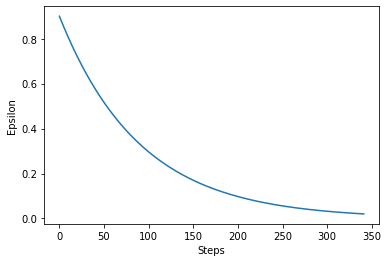

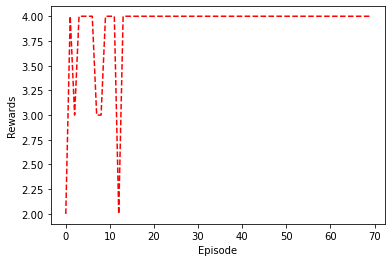

In [46]:
# DDQN agent Gridworld environment
# Epsilon Decay
plt.figure()
plt.plot(agent2.epsilon_whole)
plt.ylabel('Epsilon')
plt.xlabel('Steps')

# Reward per Step
qs_rps = []
for i in agent2.episode_log['rewards']:
    t = sum(i)
    qs_rps.append(t)

plt.figure()
plt.plot(qs_rps, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

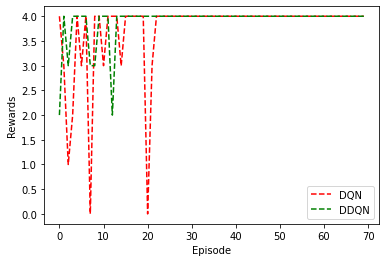

In [47]:
# plotting reward dynamics of both the agents 
qs_rps = [[],[]]
for i in agent1.episode_log['rewards']:
    t = sum(i)
    qs_rps[0].append(t)
for i in agent2.episode_log['rewards']:
    t = sum(i)
    qs_rps[1].append(t)
    
plt.figure()
plt.plot(qs_rps[0], 'r--', label = 'DQN')
plt.plot(qs_rps[1], 'g--', label = 'DDQN')
plt.ylabel('Rewards')
plt.xlabel('Episode')
legend = plt.legend()

In [51]:
# creating a neural network for mountaincar environment
class NN2(nn.Module):
    def __init__(self,seed):
        super(NN2, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(2, 22)
        self.fc2 = nn.Linear(22, 64)
        self.fc3 = nn.Linear(64, 3)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x   

In [52]:
# creating the mountaincar environment for DQN agent
env3 = gym.make('MountainCar-v0')
env3.seed(0)
print(env3.action_space)
print(env3.observation_space)

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [53]:
# creating a DQN agent for the mountain car environment
class DQNagent2:
    def __init__(self, env, nn, seed):
        self.env = env
        self.action_space = env.action_space.n
        self.policy_net = nn(seed).to(device)
        self.target_net = nn(seed).to(device)
        self.curr_mem = 0
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.episode_log = {'actions': [], 'rewards': [], 'epsilon': []}
        self.seed = random.seed(seed)

        self.env_rew = -110
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = 64
        self.gamma = 0.9
        self.decay = math.exp(-1/69)
        self.num_episodes = 300
        self.max_time = 200
        self.eps = 0.9
        self.replay_memory = np.empty(self.num_episodes*self.max_time, object)


    def add_memory(self, memory):
        self.replay_memory[self.curr_mem] = memory
        self.curr_mem += 1
        
    def sample(self, sample_size):
        return random.sample(range(0,self.curr_mem), sample_size)
        
    def greedy_action(self, states, eps):
        if random.random() > eps:
            self.policy_net.eval()
            with torch.no_grad():  
                ga = self.policy_net(states)
            self.policy_net.train()
            return torch.argmax(ga)
        else:
            return torch.tensor(random.randrange(self.action_space), device = device) 

    def optimization_time(self):
        if self.curr_mem >= self.batch_size:
            batch = self.sample(self.batch_size)
            states = torch.tensor([self.replay_memory[i][0] for i in batch], dtype = torch.float, device = device)
            rewards = torch.tensor([self.replay_memory[i][2] for i in batch], dtype = torch.float, device = device)
            next_states = torch.tensor([self.replay_memory[i][3] for i in batch], dtype = torch.float, device = device)
            done = [1 if self.replay_memory[i][4]==False else 0 for i in batch]
            actions = [self.replay_memory[i][1] for i in batch]
            
            policy_action_values = []
            t = 0
            for i in states:
                policy_action_values.append(self.policy_net(i)[actions[t]])
                t = t+1
            
            next_state_values = []
            for i in next_states:

                next_best_states = self.target_net(i).detach()
                next_state_values.append(max(next_best_states))
         
            expected_state_values = [next_state_values[i]*self.gamma*done[i] + rewards[i] for i in range(len(next_state_values))]
            policy_action_values = torch.stack(tuple(policy_action_values))
            expected_state_values = torch.stack(tuple(expected_state_values))
            
            self.loss = F.mse_loss(expected_state_values, policy_action_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()  
        
        else:
            return
            
    def start_learning(self):
        for i in range(self.num_episodes):
            if i%5 == 0:
                print(i,' episodes complete')
            self.action_log = []
            self.reward_log = []
            self.eps =  self.eps*self.decay
            
            state = self.env.reset()
            d = False
            for t in range(self.max_time):
                if d == True:
                    break
                else:
                    action = self.greedy_action(torch.tensor(state,dtype=torch.float,device=device),self.eps)
                    o,r,d,info = self.env.step(action.item())
                    self.action_log.append(action)
                    self.reward_log.append(r)
                    self.add_memory([state,action.tolist(),r,o,d])
                    state = o
                    if t%3 == 0:
                        self.optimization_time()
                
            self.episode_log['actions'].append(self.action_log)
            self.episode_log['rewards'].append(self.reward_log)
            self.episode_log['epsilon'].append(self.eps)
            
            if i%5 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
                
        print('complete')    

In [54]:
agent3 = DQNagent2(env3,NN2,123)
agent3.start_learning()

0  episodes complete
5  episodes complete


KeyboardInterrupt: 

Text(0.5, 0, 'Episode')

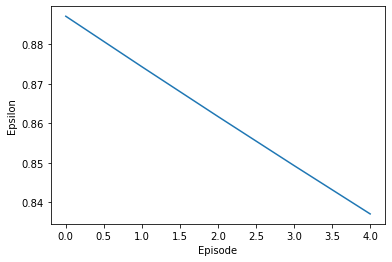

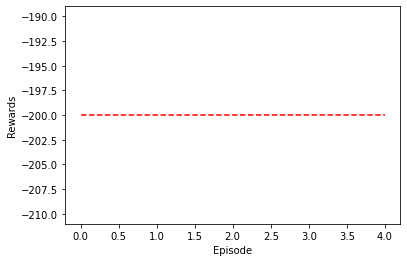

In [55]:
# DQN agent Mountain Car environment
# Epsilon Decay
plt.figure()
plt.plot([i for i in agent3.episode_log['epsilon']])
plt.ylabel('Epsilon')
plt.xlabel('Episode')

# Reward per Step
qs_rps = []
for i in agent3.episode_log['rewards']:
    t = sum(i)
    qs_rps.append(t)

plt.figure()
plt.plot(qs_rps, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

In [56]:
# creating a mountaincar environment for DDQN agent
env4 = gym.make('MountainCar-v0')
env4.seed(0)
print(env4.action_space)
print(env4.observation_space)

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [57]:
# creating a DDQN agent for the mountaincar environment
class DDQNagent2:
    def __init__(self, env, nn, seed):
        self.env = env
        self.action_space = env.action_space.n
        self.policy_net = nn(seed).to(device)
        self.target_net = nn(seed).to(device)
        self.curr_mem = 0
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.episode_log = {'actions': [], 'rewards': [], 'epsilon': []}
        self.seed = random.seed(seed)

        
        self.env_rew = -110
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = 64
        self.gamma = 0.9
        self.decay = math.exp(-1/69)
        self.num_episodes = 300
        self.max_time = 200
        self.eps = 0.9
        self.replay_memory = np.empty(self.num_episodes*self.max_time, object)


    def add_memory(self, memory):
        self.replay_memory[self.curr_mem] = memory
        self.curr_mem += 1
        
    def sample(self, sample_size):
        return random.sample(range(0,self.curr_mem), sample_size)
        
    def greedy_action(self, states, eps):
        if random.random() > eps:
            self.policy_net.eval()
            with torch.no_grad():  
                ga = self.policy_net(states)
            self.policy_net.train()
            return torch.argmax(ga)
        else:
            return torch.tensor(random.randrange(self.action_space), device = device) 

    def optimization_time(self):
        if self.curr_mem >= self.batch_size:
            batch = self.sample(self.batch_size)
            states = torch.tensor([self.replay_memory[i][0] for i in batch], dtype = torch.float, device = device)
            rewards = torch.tensor([self.replay_memory[i][2] for i in batch], dtype = torch.float, device = device)
            next_states = torch.tensor([self.replay_memory[i][3] for i in batch], dtype = torch.float, device = device)
            done = [1 if self.replay_memory[i][4]==False else 0 for i in batch]
            actions = [self.replay_memory[i][1] for i in batch]
            
            policy_action_values = []
            t = 0
            for i in states:
                policy_action_values.append(self.policy_net(i)[actions[t]])
                t = t+1
            
            next_state_values = []
            for i in next_states:

                next_best_states = self.target_net(i).detach()
                next_best_act = torch.argmax(next_best_states)
                next_svs = self.policy_net(i).detach()
                next_state_values.append(next_svs[next_best_act])
         
            expected_state_values = [next_state_values[i]*self.gamma*done[i] + rewards[i] for i in range(len(next_state_values))]
            policy_action_values = torch.stack(tuple(policy_action_values))
            expected_state_values = torch.stack(tuple(expected_state_values))
            
            self.loss = F.mse_loss(expected_state_values, policy_action_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()  
        
        else:
            return
            
    def start_learning(self):
        for i in range(self.num_episodes):
            if i%5 == 0:
                print(i,' episodes complete')
            self.action_log = []
            self.reward_log = []
            self.eps =  self.eps*self.decay
            
            state = self.env.reset()
            d = False
            for t in range(self.max_time):
                if d == True:
                    break
                else:
                    action = self.greedy_action(torch.tensor(state,dtype=torch.float,device=device),self.eps)
                    o,r,d,info = self.env.step(action.item())
                    self.action_log.append(action)
                    self.reward_log.append(r)
                    self.add_memory([state,action.tolist(),r,o,d])
                    state = o
                    if t%3 == 0:
                        self.optimization_time()
                
            self.episode_log['actions'].append(self.action_log)
            self.episode_log['rewards'].append(self.reward_log)
            self.episode_log['epsilon'].append(self.eps)

            if i%5 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
        print('complete')    

In [58]:
agent4 = DDQNagent2(env4,NN2,126)
agent4.start_learning()

0  episodes complete
5  episodes complete


KeyboardInterrupt: 

Text(0.5, 0, 'Episode')

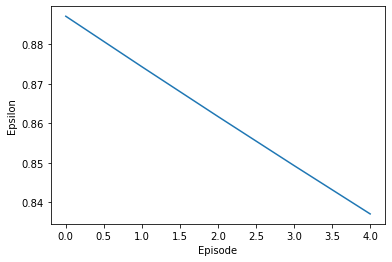

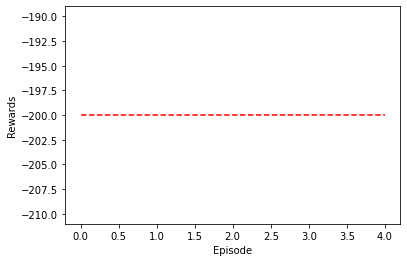

In [59]:
# DDQN agent Mountain Car environment
# Epsilon Decay
plt.figure()
plt.plot([i for i in agent4.episode_log['epsilon']])
plt.ylabel('Epsilon')
plt.xlabel('Episode')

# Reward per Step
qs_rps = []
for i in agent4.episode_log['rewards']:
    t = sum(i)
    qs_rps.append(t)

plt.figure()
plt.plot(qs_rps, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

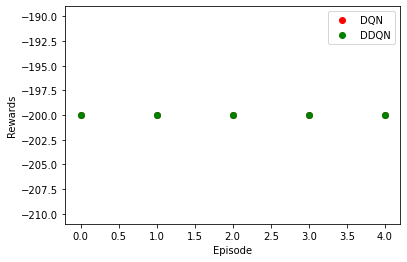

In [60]:
# plotting reward dynamics of both the agents 
qs_rps = [[],[]]
for i in agent3.episode_log['rewards']:
    t = sum(i)
    qs_rps[0].append(t)
for i in agent4.episode_log['rewards']:
    t = sum(i)
    qs_rps[1].append(t)
    
plt.figure()
plt.plot(qs_rps[0], 'ro', label = 'DQN')
plt.plot(qs_rps[1], 'go', label = 'DDQN')
plt.ylabel('Rewards')
plt.xlabel('Episode')
legend = plt.legend()

In [63]:
# creating the lunar lander environment for the DQN agent
env5 = gym.make('LunarLander-v2')
print(env5.action_space)
print(env5.observation_space)

Discrete(4)
Box(-inf, inf, (8,), float32)


In [64]:
# creating a DQN agent for the Lunar Lander environment
class DQNagent3:
    def __init__(self, env, nn, seed):
        self.env = env
        self.action_space = env.action_space.n
        self.policy_net = nn(seed).to(device)
        self.target_net = nn(seed).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.episode_log = {'actions': [], 'rewards': [], 'epsilon': []}
        self.curr_mem = 0
        self.seed = random.seed(seed)

        self.env_rew = 200   
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = 64
        self.gamma = 0.9
        self.decay = math.exp(-1/310)
        self.num_episodes = 1000
        self.max_time = 1000
        self.eps = 0.9
        self.replay_memory = np.empty(self.num_episodes*self.max_time, object)
        

    def add_memory(self, memory):
        self.replay_memory[self.curr_mem] = memory
        self.curr_mem += 1
        
    def sample(self, sample_size):
        return random.sample(range(0,self.curr_mem), sample_size)
        
    def greedy_action(self, states, eps):
        if random.random() > eps:
            self.policy_net.eval()
            with torch.no_grad():  
                ga = self.policy_net(states)
            self.policy_net.train()
            return torch.argmax(ga)
        else:
            return torch.tensor(random.randrange(self.action_space), device = device) 

    def optimization_time(self):
        if self.curr_mem >= self.batch_size:
            batch = self.sample(self.batch_size)
            states = torch.tensor([self.replay_memory[i][0] for i in batch], dtype = torch.float, device = device)
            rewards = torch.tensor([self.replay_memory[i][2] for i in batch], dtype = torch.float, device = device)
            next_states = torch.tensor([self.replay_memory[i][3] for i in batch], dtype = torch.float, device = device)
            done = [1 if self.replay_memory[i][4]==False else 0 for i in batch]
            actions = [self.replay_memory[i][1] for i in batch]
            
            policy_action_values = []
            t = 0
            for i in states:
                policy_action_values.append(self.policy_net(i)[actions[t]])
                t = t+1
            
            next_state_values = []
            for i in next_states:

                next_best_states = self.target_net(i).detach()
                next_state_values.append(max(next_best_states))
         
            expected_state_values = [next_state_values[i]*self.gamma*done[i] + rewards[i] for i in range(len(next_state_values))]
            policy_action_values = torch.stack(tuple(policy_action_values))
            expected_state_values = torch.stack(tuple(expected_state_values))
            
            self.loss = F.mse_loss(expected_state_values, policy_action_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()  
        
        else:
            return
            
    def start_learning(self):
        for i in range(self.num_episodes):
            if i%5 == 0:
                print(i,' episodes complete')
            self.action_log = []
            self.reward_log = []
            self.eps =  self.eps*self.decay
            
            state = self.env.reset()
            d = False
            for t in range(self.max_time):
                if d == True:
                    break
                else:
                    action = self.greedy_action(torch.tensor(state,dtype=torch.float,device=device),self.eps)
                    o,r,d,info = self.env.step(action.item())
                    self.action_log.append(action)
                    self.reward_log.append(r)
                    self.add_memory([state,action.tolist(),r,o,d])
                    state = o
                    if t%4 == 0:
                        self.optimization_time()
                
            self.episode_log['actions'].append(self.action_log)
            self.episode_log['rewards'].append(self.reward_log)
            self.episode_log['epsilon'].append(self.eps)
            
            if i%4 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
        print('complete')    

In [65]:
agent5 = DQNagent3(env5,NN,123)
agent5.start_learning()

0  episodes complete


KeyboardInterrupt: 

Text(0.5, 0, 'Episode')

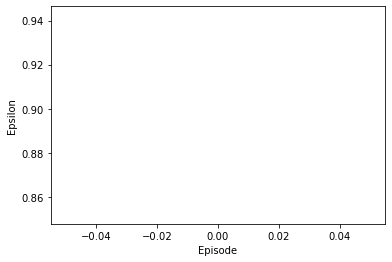

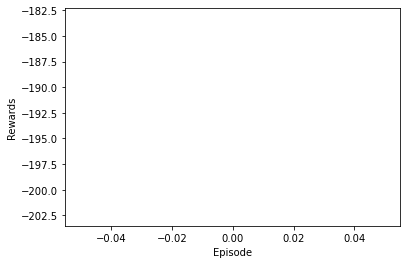

In [66]:
# DQN agent Lunar Lander Environment
# Epsilon Decay
plt.figure()
plt.plot([i for i in agent5.episode_log['epsilon']])
plt.ylabel('Epsilon')
plt.xlabel('Episode')

# Reward per Step
qs_rps = []
for i in agent5.episode_log['rewards']:
    t = sum(i)
    qs_rps.append(t)

plt.figure()
plt.plot(qs_rps, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

In [67]:
# creating the lunar lander environment for the DDQN agent
env6 = gym.make('LunarLander-v2')
print(env6.action_space)
print(env6.observation_space)

Discrete(4)
Box(-inf, inf, (8,), float32)


In [68]:
# creating a DDQN agent for the Lunar Lander environment
class DDQNagent3:
    def __init__(self, env, nn, seed):
        self.env = env
        self.action_space = env.action_space.n
        self.policy_net = nn(seed).to(device)
        self.target_net = nn(seed).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.episode_log = {'actions': [], 'rewards': [], 'epsilon': []}
        self.curr_mem = 0
        self.seed = random.seed(seed)

        self.env_rew = 200   
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = 64
        self.gamma = 0.9
        self.decay = math.exp(-1/310)
        self.num_episodes = 1000
        self.max_time = 1000
        self.eps = 0.9
        self.replay_memory = np.empty(self.num_episodes*self.max_time, object)
        

    def add_memory(self, memory):
        self.replay_memory[self.curr_mem] = memory
        self.curr_mem += 1
        
    def sample(self, sample_size):
        return random.sample(range(0,self.curr_mem), sample_size)
        
    def greedy_action(self, states, eps):
        if random.random() > eps:
            self.policy_net.eval()
            with torch.no_grad():  
                ga = self.policy_net(states)
            self.policy_net.train()
            return torch.argmax(ga)
        else:
            return torch.tensor(random.randrange(self.action_space), device = device) 


    def optimization_time(self):
        if self.curr_mem >= self.batch_size:
            batch = self.sample(self.batch_size)
            states = torch.tensor([self.replay_memory[i][0] for i in batch], dtype = torch.float, device = device)
            rewards = torch.tensor([self.replay_memory[i][2] for i in batch], dtype = torch.float, device = device)
            next_states = torch.tensor([self.replay_memory[i][3] for i in batch], dtype = torch.float, device = device)
            done = [1 if self.replay_memory[i][4]==False else 0 for i in batch]
            actions = [self.replay_memory[i][1] for i in batch]
            
            policy_action_values = []
            t = 0
            for i in states:
                policy_action_values.append(self.policy_net(i)[actions[t]])
                t = t+1
            
            next_state_values = []
            for i in next_states:

                next_best_states = self.target_net(i).detach()
                next_best_act = torch.argmax(next_best_states)
                next_svs = self.policy_net(i).detach()
                next_state_values.append(next_svs[next_best_act])
         
            expected_state_values = [next_state_values[i]*self.gamma*done[i] + rewards[i] for i in range(len(next_state_values))]
            policy_action_values = torch.stack(tuple(policy_action_values))
            expected_state_values = torch.stack(tuple(expected_state_values))
            
            self.loss = F.mse_loss(expected_state_values, policy_action_values)
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()  
        
        else:
            return
            
    def start_learning(self):
        for i in range(self.num_episodes):
            if i%5 == 0:
                print(i,' episodes complete')
            self.action_log = []
            self.reward_log = []
            self.eps =  self.eps*self.decay
            
            state = self.env.reset()
            d = False
            for t in range(self.max_time):
                if d == True:
                    break
                else:
                    action = self.greedy_action(torch.tensor(state,dtype=torch.float,device=device),self.eps)
                    o,r,d,info = self.env.step(action.item())
                    self.action_log.append(action)
                    self.reward_log.append(r)
                    self.add_memory([state,action.tolist(),r,o,d])
                    state = o
                    if t%4 == 0:
                        self.optimization_time()
                
            self.episode_log['actions'].append(self.action_log)
            self.episode_log['rewards'].append(self.reward_log)
            self.episode_log['epsilon'].append(self.eps)
            
            if i%4 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                
        print('complete')    

In [69]:
agent6 = DDQNagent3(env6,NN,123)
agent6.start_learning()

0  episodes complete


KeyboardInterrupt: 

Text(0.5, 0, 'Episode')

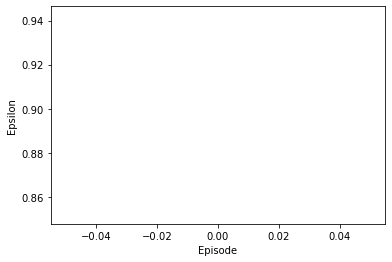

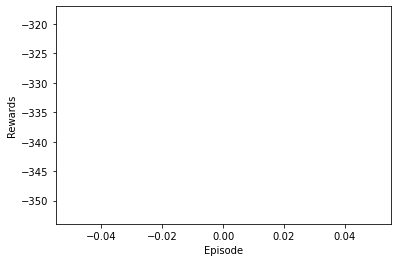

In [70]:
# DDQN agent Lunar Lander environment
# Epsilon Decay
plt.figure()
plt.plot([i for i in agent6.episode_log['epsilon']])
plt.ylabel('Epsilon')
plt.xlabel('Episode')

# Reward per Step
qs_rps = []
for i in agent6.episode_log['rewards']:
    t = sum(i)
    qs_rps.append(t)

plt.figure()
plt.plot(qs_rps, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

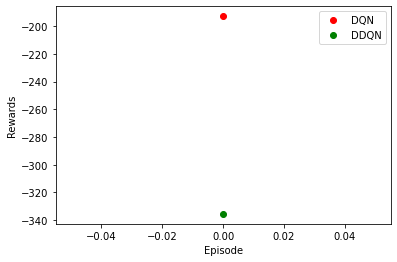

In [71]:
# plotting reward dynamics of both the agents for the lunar Lander environment
qs_rps = [[],[]]
for i in agent5.episode_log['rewards']:
    t = sum(i)
    qs_rps[0].append(t)
for i in agent6.episode_log['rewards']:
    t = sum(i)
    qs_rps[1].append(t)
    
plt.figure()
plt.plot(qs_rps[0], 'ro', label = 'DQN')
plt.plot(qs_rps[1], 'go', label = 'DDQN')
plt.ylabel('Rewards')
plt.xlabel('Episode')
legend = plt.legend()

In [23]:
# Uncomment the code below to see the stacked area plot for the DQN agent in the Lunar Lander environment

#qs_a0 = []
#qs_a1 = []
#qs_a2 = []
#qs_a3 = []

#for i in agent5.episode_log['actions']:
    #qs_a0.append(i.count(0))
    #qs_a1.append(i.count(1))
    #qs_a2.append(i.count(2))
    #qs_a3.append(i.count(3))


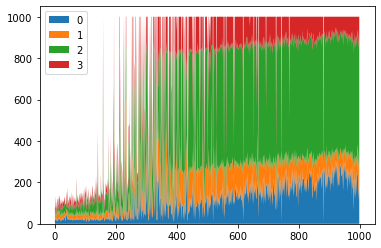

In [30]:

#plt.stackplot(range(0,1000), qs_a0, qs_a1, qs_a2, qs_a3, labels = [0,1,2,3])
#plt.legend(loc = 'upper left')
#plt.show()


In [33]:
# Uncomment the code below to see the stacked area plot for the DDQN agent in the Lunar Lander environment


#qb_a0 = []
#qb_a1 = []
#qb_a2 = []
#qb_a3 = []

#for i in agent6.episode_log['actions']:
    #qb_a0.append(i.count(0))
    #qb_a1.append(i.count(1))
    #qb_a2.append(i.count(2))
    #qb_a3.append(i.count(3))


In [32]:

#plt.stackplot(range(0,1000), qb_a0, qb_a1, qb_a2, qb_a3, labels = [0,1,2,3])
#plt.legend(loc = 'upper left')
#plt.show()
